# Exercise 4 - Consume Data using Fabric Data Science experience
## Objective<p>
In the context of this exercise, you will take the role of a data scientist who has been given the task to explore, clean and transform a dataset containing taxicab trip data, and build a machine learning model to predict trip duration at scale on a large dataset.
We will use the The New York taxi greencab dataset, which is a large-scale dataset containing taxi trips in the city from 2009 to 2018. The dataset includes various features such as pick-up and drop-off dates, times, locations, fares, payment types, and passenger counts.The dataset can be used for various purposes such as analyzing traffic patterns, demand trends, pricing strategies, and driver behavior.

## Outline

1) **Read data from Fabric lakehouse tables using Apache Spark**
2) **Explore and Visualize Data using Notebooks**
3) **Perform Data Cleansing and preparation using Apache Spark**
4) **Train and register machine learning models**
5) **Perform Batch Scoring and save predictions to lakehouse**
6) **Create a PowerBI report on the predictions using DirectLake**

# Module 1: Read data from Fabric lakehouse tables using Apache Spark
**Lakehouse**:
A lakehouse is a collection of files/folders/tables that represent a database over a data lake used by 
the Spark engine and SQL engine for big data processing and that includes enhanced capabilities for 
ACID transactions when using the open-source Delta formatted tables.

**Delta Lake**:Delta Lake is an open-source storage layer that brings ACID transactions, scalable metadata management, and batch and streaming data processing to Apache Spark. A Delta Lake table is a data table format that extends Parquet data files with a file-based transaction log for ACID transactions and scalable metadata management.

In [1]:
# Read delta table from lakehouse
data = spark.read.format("delta").load("Tables/nyctaxi_green")

StatementMeta(, 2f13b9ac-889c-45f3-84b1-3dcdafd759a7, 3, Finished, Available)

# Module 2: Explore and Visualize Data

In this module we will use seaborn, a Python data visualization library that provides a high-level interface for building visuals on dataframes and arrays. You can learn more about seaborn [here](https://seaborn.pydata.org/).

##### Import visualization libraries and set figure config

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
sns.set_theme(style="whitegrid", palette="tab10", rc = {'figure.figsize':(9,6)})

StatementMeta(, 2f13b9ac-889c-45f3-84b1-3dcdafd759a7, 4, Finished, Available)

In [3]:
# Note: For the purpose of minimizing runtime in this exercise, We are using a 1/1000 sample to explore and visualize ingested data
SEED = 1234
sampled_df = data.sample(True, 0.001, seed=SEED).toPandas()
sampled_df

StatementMeta(, 2f13b9ac-889c-45f3-84b1-3dcdafd759a7, 5, Finished, Available)

,vendorID,lpepPickupDatetime,lpepDropoffDatetime,passengerCount,tripDistance,puLocationId,doLocationId,pickupLongitude,pickupLatitude,dropoffLongitude,...,paymentType,fareAmount,extra,mtaTax,improvementSurcharge,tipAmount,tollsAmount,ehailFee,totalAmount,tripType
0,2,2017-02-16 08:08:21,2017-02-16 08:17:13,1,1.17,244,243,NaN,NaN,NaN,...,1,7.5,0.0,0.5,0.3,1.0,0.0,NaN,11.25,1.0
1,1,2017-02-10 13:27:26,2017-02-10 13:42:52,1,4.40,244,59,NaN,NaN,NaN,...,1,15.0,0.0,0.5,0.3,1.0,0.0,NaN,16.80,1.0
2,2,2017-02-25 08:53:14,2017-02-25 09:04:02,1,2.87,43,162,NaN,NaN,NaN,...,1,11.0,0.0,0.5,0.3,1.0,0.0,NaN,12.80,1.0
3,2,2017-02-04 19:08:12,2017-02-04 19:18:19,1,1.30,41,74,NaN,NaN,NaN,...,1,8.0,0.0,0.5,0.3,1.0,0.0,NaN,9.80,1.0
4,2,2017-02-05 12:18:57,2017-02-05 12:24:41,1,1.48,41,236,NaN,NaN,NaN,...,1,6.5,0.0,0.5,0.3,1.0,0.0,NaN,8.30,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76283,2,2017-05-16 12:42:42,2017-05-16 12:46:03,1,0.70,75,74,NaN,NaN,NaN,...,2,4.5,0.0,0.5,0.3,0.0,0.0,NaN,5.30,1.0
76284,1,2017-05-12 05:58:01,2017-05-12 06:05:30,1,1.50,112,255,NaN,NaN,NaN,...,2,7.5,0.0,0.5,0.3,0.0,0.0,NaN,8.30,1.0
76285,2,2017-05-12 08:48:33,2017-05-12 08:55:21,1,1.56,75,74,NaN,NaN,NaN,...,2,7.5,0.0,0.5,0.3,0.0,0.0,NaN,8.30,1.0
76286,2,2017-05-30 10:04:52,2017-05-30 10:13:28,1,1.17,7,226,NaN,NaN,NaN,...,2,7.5,0.0,0.5,0.3,0.0,0.0,NaN,8.30,1.0


##### Visual 1: Distribution of trip duration(minutes) on linear and logarithmic scale

StatementMeta(, 2f13b9ac-889c-45f3-84b1-3dcdafd759a7, 6, Finished, Available)

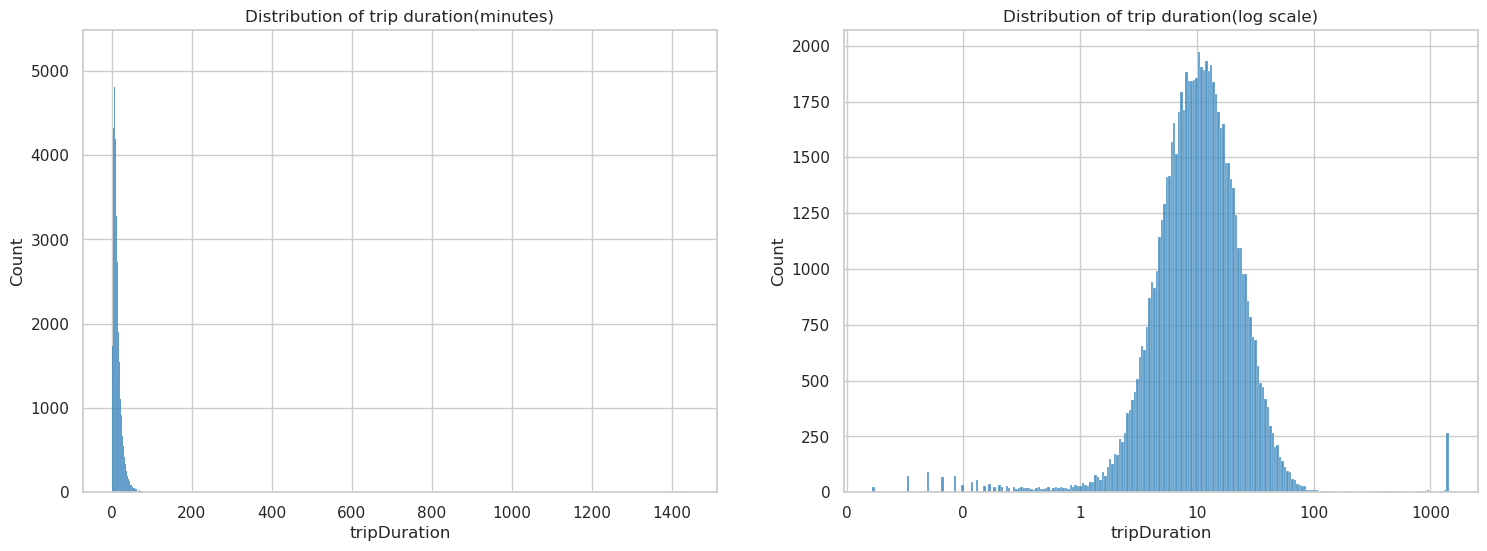

In [4]:
## Compute trip duration(in minutes) on the sample using pandas
sampled_df['tripDuration'] = (sampled_df['lpepDropoffDatetime'] - sampled_df['lpepPickupDatetime']).astype('timedelta64[s]').dt.seconds/60
sampled_df = sampled_df[sampled_df["tripDuration"] > 0]

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.histplot(ax=axes[0],data=sampled_df,
            x="tripDuration",
            stat="count",
            discrete=True).set(title='Distribution of trip duration(minutes)')
sns.histplot(ax=axes[1],data=sampled_df,
            x="tripDuration",
            stat="count", 
            log_scale= True).set(title='Distribution of trip duration(log scale)')
axes[1].xaxis.set_major_formatter(mticker.ScalarFormatter())
plt.show()

#### Visual 2: Lets create bins to visualize duration of trips better

StatementMeta(, 2f13b9ac-889c-45f3-84b1-3dcdafd759a7, 7, Finished, Available)

/tmp/ipykernel_5722/2320726535.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_df.loc[sampled_df['tripDuration'].between(0, 10, 'both'), 'durationBin'] = '< 10 Mins'


Text(0, 0.5, 'Frequency')

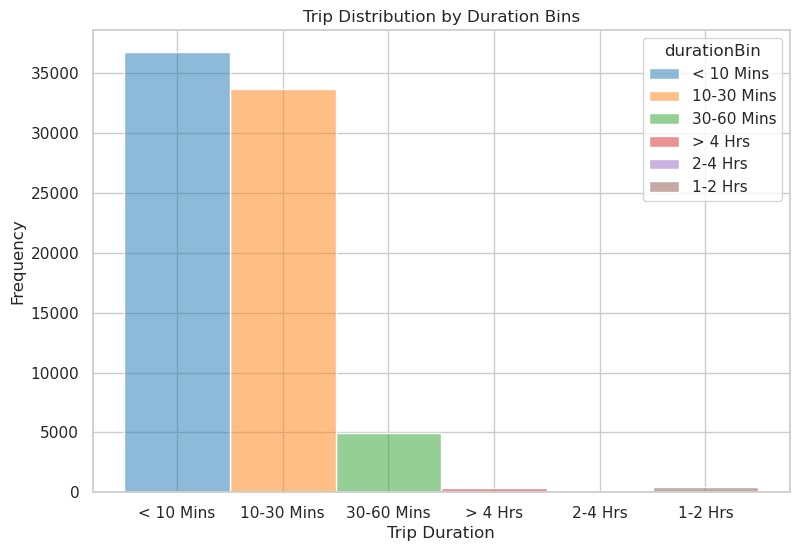

In [5]:
## Create bins for tripDuration column
sampled_df.loc[sampled_df['tripDuration'].between(0, 10, 'both'), 'durationBin'] = '< 10 Mins'
sampled_df.loc[sampled_df['tripDuration'].between(10, 30, 'both'), 'durationBin'] = '10-30 Mins'
sampled_df.loc[sampled_df['tripDuration'].between(30, 60, 'both'), 'durationBin'] = '30-60 Mins'
sampled_df.loc[sampled_df['tripDuration'].between(60, 120, 'right'), 'durationBin'] = '1-2 Hrs'
sampled_df.loc[sampled_df['tripDuration'].between(120, 240, 'right'), 'durationBin'] = '2-4 Hrs'
sampled_df.loc[sampled_df['tripDuration'] > 240, 'durationBin'] = '> 4 Hrs'

# Plot histogram using the binned column
sns.histplot(data=sampled_df, x="durationBin", stat="count", discrete=True, hue = "durationBin")
plt.title("Trip Distribution by Duration Bins")
plt.xlabel('Trip Duration')
plt.ylabel('Frequency')

#### Visual 3: Visualize the distribution of tripDuration and tripDistance and classify by passengerCount

StatementMeta(, 2f13b9ac-889c-45f3-84b1-3dcdafd759a7, 8, Finished, Available)

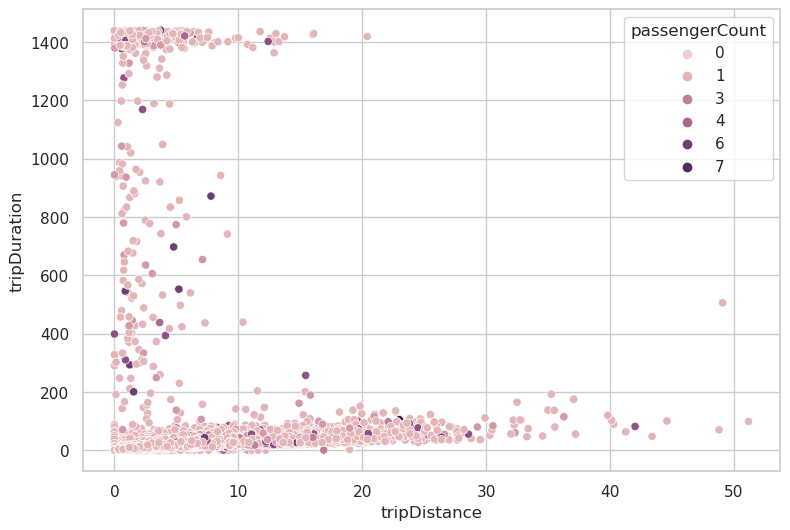

In [6]:
sns.scatterplot(data=sampled_df, x="tripDistance", y="tripDuration", hue="passengerCount")
plt.show()

#### Visual 4: Visualize distribution of passengercount per trip

StatementMeta(, 2f13b9ac-889c-45f3-84b1-3dcdafd759a7, 9, Finished, Available)

Text(0, 0.5, 'Number of trips')

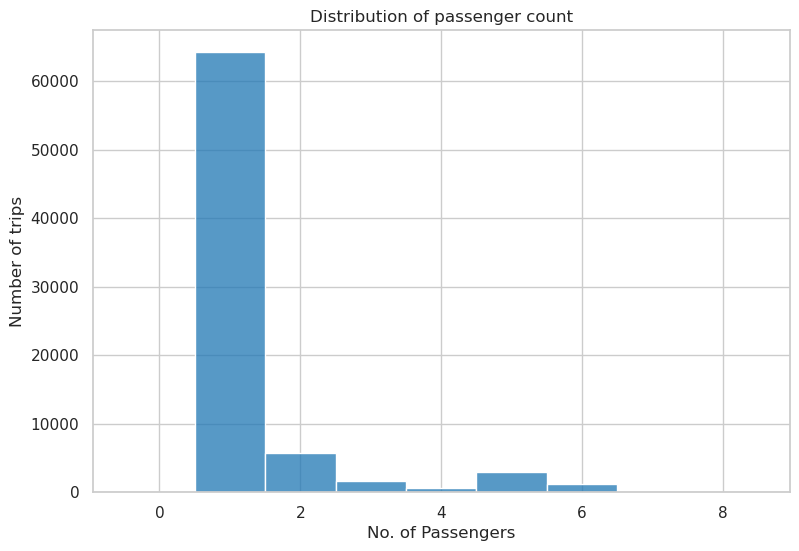

In [7]:
sns.histplot(data=sampled_df, x="passengerCount", stat="count", discrete=True)
plt.title("Distribution of passenger count")
plt.xlabel('No. of Passengers')
plt.ylabel('Number of trips')

#### Visual 5:  Create boxplots to visualize the distribution of tripDuration by passenger count
A boxplot is a useful tool to understand the variability, symmetry, and outliers of the data.
- In first figure lets visualize tripDuration without removing any outliers
- In the second figure we are removing trips with duration greater than 3 hours and zero passengers.

StatementMeta(, 2f13b9ac-889c-45f3-84b1-3dcdafd759a7, 10, Finished, Available)

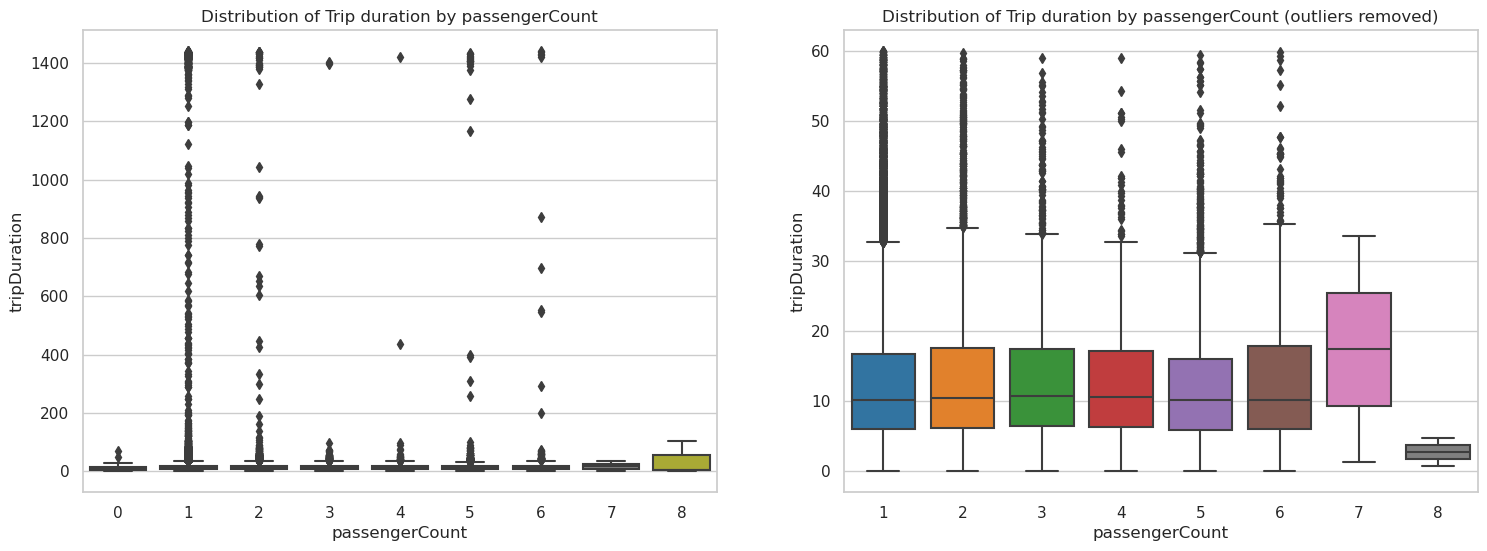

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.boxplot(ax=axes[0], data=sampled_df, x="passengerCount", y="tripDuration").set(title='Distribution of Trip duration by passengerCount')
sampleddf_clean = sampled_df[(sampled_df["passengerCount"] > 0) & (sampled_df["tripDuration"] < 60)]
sns.boxplot(ax=axes[1], data=sampleddf_clean, x="passengerCount", y="tripDuration").set(title='Distribution of Trip duration by passengerCount (outliers removed)')
plt.show()

#### Visual 6: Analyze the relationship of tripDuration and fareAmount classified by paymentType and VendorId using a scatterplot/subplots

StatementMeta(, 2f13b9ac-889c-45f3-84b1-3dcdafd759a7, 11, Finished, Available)

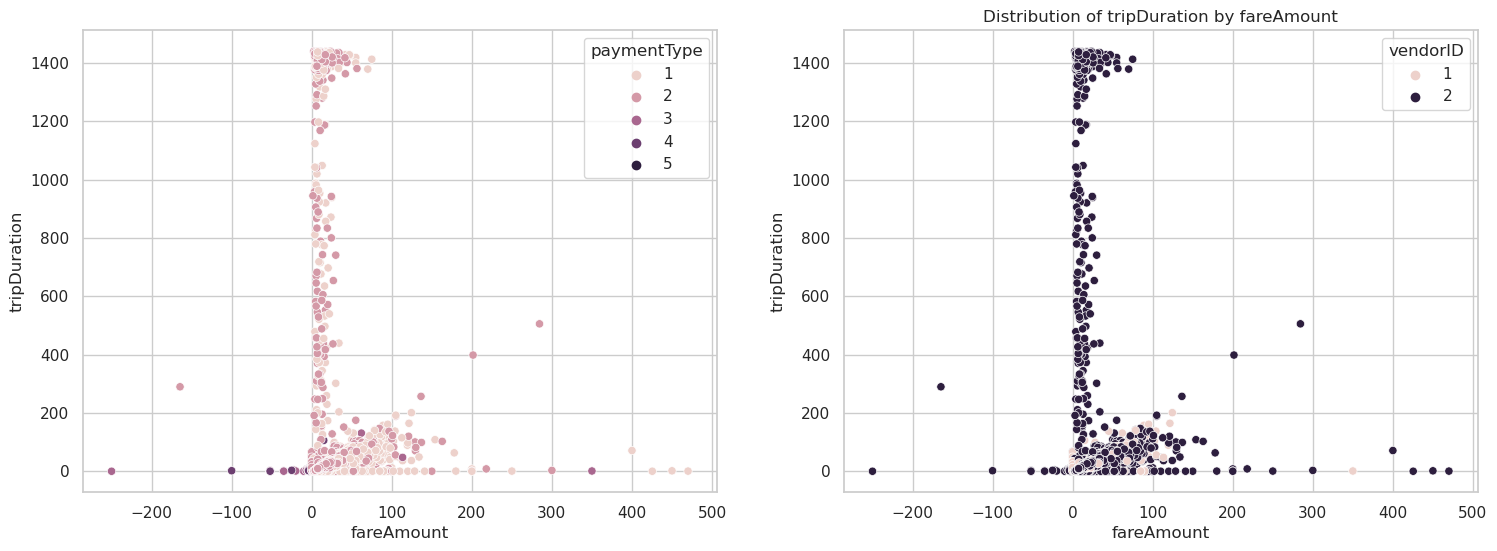

In [9]:
f, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.scatterplot(ax =axes[0], data=sampled_df, x="fareAmount", y="tripDuration",  hue="paymentType")
sns.scatterplot(ax =axes[1],data=sampled_df, x="fareAmount", y="tripDuration",  hue="vendorID")
plt.title("Distribution of tripDuration by fareAmount")
plt.show()

#### Visual 7: Analyze the frequency of the taxi trips by hour of the day

StatementMeta(, 2f13b9ac-889c-45f3-84b1-3dcdafd759a7, 12, Finished, Available)

/tmp/ipykernel_5722/2668449046.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_df['hour'] = sampled_df['lpepPickupDatetime'].dt.hour
/tmp/ipykernel_5722/2668449046.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_df['dayofweek'] = sampled_df['lpepDropoffDatetime'].dt.dayofweek
/tmp/ipykernel_5722/2668449046.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

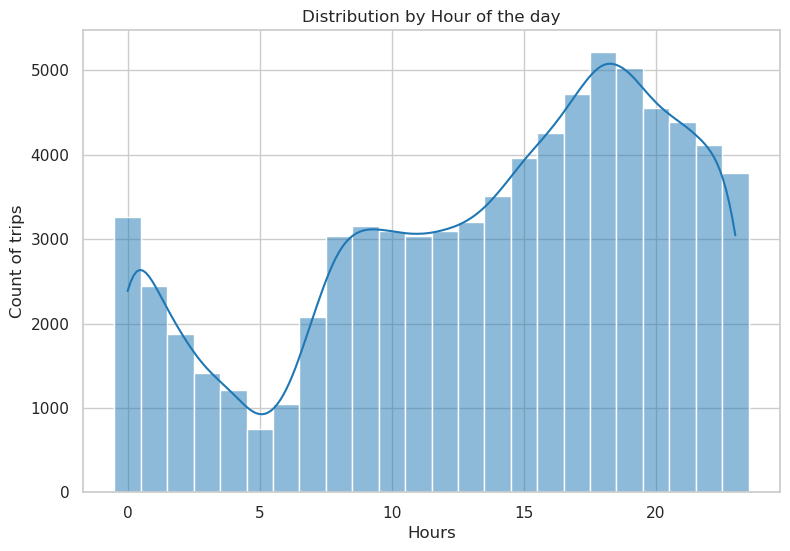

In [10]:
sampled_df['hour'] = sampled_df['lpepPickupDatetime'].dt.hour
sampled_df['dayofweek'] = sampled_df['lpepDropoffDatetime'].dt.dayofweek
sampled_df['dayname'] = sampled_df['lpepDropoffDatetime'].dt.day_name()
sns.histplot(data=sampled_df, x="hour", stat="count", discrete=True, kde=True)
plt.title("Distribution by Hour of the day")
plt.xlabel('Hours')
plt.ylabel('Count of trips')
plt.show()

#### Visual 8: Analyze average taxi trip duration by hour and day of the week using a heatmap

StatementMeta(, 2f13b9ac-889c-45f3-84b1-3dcdafd759a7, 13, Finished, Available)

[Text(0.5, 32.249999999999986, '')]

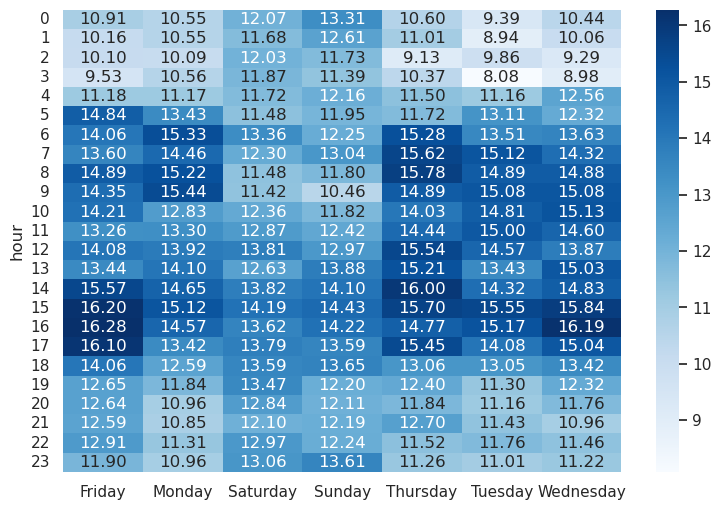

In [11]:
pv_df = sampled_df[sampled_df["tripDuration"]<180]\
        .groupby(["hour","dayname"]).mean("tripDuration")\
        .reset_index().pivot(index = "hour", columns= "dayname", values = "tripDuration")
sns.heatmap(pv_df,annot=True,fmt='.2f', cmap="Blues").set(xlabel=None)

#### Visual 9: Create a Correlation plot 
A correlation plot is a useful tool for exploring the relationships among numerical variables in a dataset. It displays the data points for each pair of variables as a scatterplot, and also calculates the correlation coefficient for each pair. The correlation coefficient indicates how strongly and in what direction the variables are related. A positive correlation means that the variables tend to increase or decrease together, while a negative correlation means that they tend to move in opposite directions.

StatementMeta(, 2f13b9ac-889c-45f3-84b1-3dcdafd759a7, 14, Finished, Available)

<Axes: >

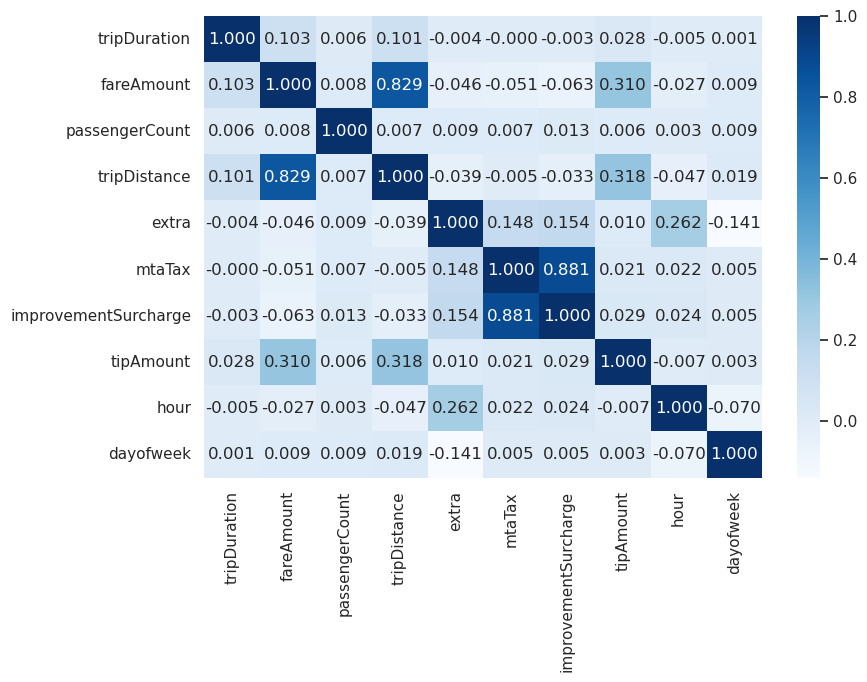

In [12]:
cols_to_corr = ['tripDuration','fareAmount', 'passengerCount', 'tripDistance', 'extra', 'mtaTax',
       'improvementSurcharge', 'tipAmount', 'hour',"dayofweek"]
sns.heatmap(data = sampled_df[cols_to_corr].corr(),annot=True,fmt='.3f', cmap="Blues")

#### Summary of observations from data exploration:

1) Some trips in the sample have passenger count of 0 but most trips have a passenger count between 1-6.
2) tripDuration column has outliers with a comparatively smmall number of trips having trip duration of greater than 3 hours.
3) The outliers for TripDuration are for specifically for vendorId 2.
4) Some trips have zero tripdistance and hence can be treated cancelled and filtered out
5) A small number of trips have no passengers(0) and hence can be filtered out
6) fareAmount column contains negative outliers which can be removed from training.
6) The number of trips start rising around 16:00 hours and peaks between 18:00 - 19:00 hours.

# Module 3: Perform Data Cleansing and preparation using Apache Spark

#### Load NYC taxi Data from lakehouse delta table

In [13]:
nytaxi_df = spark.read.format("delta").load("Tables/nyctaxi_green")

StatementMeta(, 2f13b9ac-889c-45f3-84b1-3dcdafd759a7, 15, Finished, Available)

##### Get Summary Statistics of all the columns using Spark dataframe summary

In [14]:
display(nytaxi_df.summary())

StatementMeta(, 2f13b9ac-889c-45f3-84b1-3dcdafd759a7, 16, Finished, Available)

SynapseWidget(Synapse.DataFrame, 9fd5688f-621a-4930-8326-eb81c3775ad3)

#### Clean data and add additional derived columns

**<u>Add derived Columns</u>**
- pickupDate - convert datetime to date for visualizations and reporting.
- weekDay - day number of the week
- weekDayName - day names abbreviated.
- dayofMonth - day number of the month
- pickupHour - hour of pickup time
- tripDuration - representing duration in minutes of the trip.
- timeBins - Binned time of the day


**<u>Filter Conditions</u>** <p>
- fareAmount is between 0 and 100 
- tripDistance greater than 0 
- tripDuration is less than 3 hours (180 minutes) 
- passengerCount is between 1 and 8.
- startLat, startLon, endLat, endLon are not NULL.
- Remove outstation trips(outliers) tripDistance>100.


In [15]:
from pyspark.sql.functions import col,when, dayofweek, date_format, hour,unix_timestamp, round, dayofmonth, lit
nytaxidf_prep = nytaxi_df.withColumn('pickupDate', col('lpepPickupDatetime').cast('date'))\
                            .withColumn("weekDay", dayofweek(col("lpepPickupDatetime")))\
                            .withColumn("weekDayName", date_format(col("lpepPickupDatetime"), "EEEE"))\
                            .withColumn("dayofMonth", dayofweek(col("lpepPickupDatetime")))\
                            .withColumn("pickupHour", hour(col("lpepPickupDatetime")))\
                            .withColumn("tripDuration", (unix_timestamp(col("lpepDropoffDatetime")) - unix_timestamp(col("lpepPickupDatetime")))/60)\
                            .withColumn("timeBins", when((col("pickupHour") >=7) & (col("pickupHour")<=10) ,"MorningRush")\
                            .when((col("pickupHour") >=11) & (col("pickupHour")<=15) ,"Afternoon")\
                            .when((col("pickupHour") >=16) & (col("pickupHour")<=19) ,"EveningRush")\
                            .when((col("pickupHour") <=6) | (col("pickupHour")>=20) ,"Night"))\
                            .filter("""fareAmount > 0 AND fareAmount < 100 and tripDistance > 0 AND tripDistance < 100 
                                    AND tripDuration > 0 AND tripDuration <= 180 
                                    AND passengerCount > 0 AND passengerCount <= 8
                                    AND pickupLatitude IS NOT NULL AND pickupLongitude IS NOT NULL AND dropoffLatitude IS NOT NULL AND dropoffLongitude IS NOT NULL""")

StatementMeta(, 2f13b9ac-889c-45f3-84b1-3dcdafd759a7, 17, Finished, Available)

#### Save Cleansed and prepared data to lakehouse delta table

In [16]:
table_name = "nyctaxi_green_prep"
nytaxidf_prep.write.mode("overwrite").format("delta").save(f"Tables/{table_name}")
print(f"Spark dataframe saved to delta table: {table_name}")

StatementMeta(, 2f13b9ac-889c-45f3-84b1-3dcdafd759a7, 18, Finished, Available)

Spark dataframe saved to delta table: nyctaxi_green_prep


# Module 4: Train and register a machine learning model
In this module you will learn to train a machine learning model to predict the total ride duration (tripDuration) of green taxi trips in New York City based on various factors such as pickup and drop-off locations, distance, date, time, number of passengers, and rate code.

Once a model is trained, you will learn to register the trained model, and log hyperaparameters used and evaluation metrics using Fabric's native integration with the MLflow framework.

[MLflow](https://mlflow.org/docs/latest/index.html) is an open source platform for managing the machine learning lifecycle with features like Tracking, Models, and Model Registry. MLflow is natively integrated with Fabric Data Science Experience.

#### Import mlflow and create an experiment to log the run

In [17]:
# Create Experiment to Track and register model with mlflow
import mlflow
print(f"mlflow lbrary version: {mlflow.__version__}")
EXPERIMENT_NAME = "nyctaxi_tripduration"
mlflow.set_experiment(EXPERIMENT_NAME)

StatementMeta(, 2f13b9ac-889c-45f3-84b1-3dcdafd759a7, 19, Finished, Available)

mlflow lbrary version: 2.6.0


<Experiment: artifact_location='', creation_time=1710851784874, experiment_id='435bdb49-1e45-44a2-b06b-f84146c7b35f', last_update_time=None, lifecycle_stage='active', name='nyctaxi_tripduration', tags={}>

#### Read Cleansed data from lakehouse delta table (saved in module 3)

In [18]:
%%sql
SELECT YEAR(pickupDate)
FROM nyctaxi_green_prep
GROUP BY YEAR(pickupDate)

StatementMeta(, 2f13b9ac-889c-45f3-84b1-3dcdafd759a7, 20, Finished, Available)

<Spark SQL result set with 4 rows and 1 fields>

In [19]:
SEED = 1234
# note: From the perspective of the exercise, we are sampling training data to speed up the execution.
training_df = spark.read.format("delta").load("Tables/nyctaxi_green_prep")\
                        .filter("YEAR(pickupDate) IN (2013, 2014, 2015)")\
                        .sample(fraction = 0.1, seed = SEED)

StatementMeta(, 2f13b9ac-889c-45f3-84b1-3dcdafd759a7, 21, Finished, Available)

#### Perform random split to get train and test datasets and define categorical and numeric features

In [20]:
TRAIN_TEST_SPLIT = [0.75, 0.25]
train_df, test_df = training_df.randomSplit(TRAIN_TEST_SPLIT, seed=SEED)

# Cache the dataframes to improve the speed of repeatable reads
train_df.cache()
test_df.cache()

print(f"train set count:{train_df.count()}")
print(f"test set count:{test_df.count()}")

categorical_features = ["storeAndFwdFlag","timeBins","vendorID","weekDayName","pickupHour","rateCodeID"]
numeric_features = ['passengerCount', "tripDistance"]

StatementMeta(, 2f13b9ac-889c-45f3-84b1-3dcdafd759a7, 22, Finished, Available)

train set count:2660018
test set count:887929


#### Define the steps to perform additional feature engineering and train the model using Spark ML pipelines and Microsoft SynapseML library
You can learn more about Spark ML pipelines [here](https://spark.apache.org/docs/latest/ml-pipeline.html), and SynapseML is documented [here](https://microsoft.github.io/SynapseML/docs/about/)

The algorithm used for this exercise, [LightGBM](https://lightgbm.readthedocs.io/en/v3.3.2/) is a fast, distributed, high performance gradient boosting framework based on decision tree algorithms. It is an open source project developed by Microsoft and supports regression, classification and many other machine learning scenarios. Its main advantages are faster training speed, lower memory usage, better accuracy, and support for distributed learning.

In [27]:
from pyspark.ml.feature import OneHotEncoder, VectorAssembler, StringIndexer
from pyspark.ml import Pipeline
from synapse.ml.core.platform import *
from synapse.ml.lightgbm import LightGBMRegressor

# Define a pipeline steps for training a LightGBMRegressor regressor model
def lgbm_pipeline(categorical_features,numeric_features, hyperparameters):
    # String indexer
    stri = StringIndexer(inputCols=categorical_features, 
                        outputCols=[f"{feat}Idx" for feat in categorical_features]).setHandleInvalid("keep")
    # encode categorical/indexed columns
    ohe = OneHotEncoder(inputCols= stri.getOutputCols(),  
                        outputCols=[f"{feat}Enc" for feat in categorical_features])
    
    # convert all feature columns into a vector
    featurizer = VectorAssembler(inputCols=ohe.getOutputCols() + numeric_features, outputCol="features")

    # Define the LightGBM regressor
    lgr = LightGBMRegressor(
        objective = hyperparameters["objective"],
        alpha = hyperparameters["alpha"],
        learningRate = hyperparameters["learning_rate"],
        numLeaves = hyperparameters["num_leaves"],
        labelCol="tripDuration",
        numIterations = hyperparameters["iterations"],
    )
    # Define the steps and sequence of the SPark ML pipeline
    ml_pipeline = Pipeline(stages=[stri, ohe, featurizer, lgr])
    return ml_pipeline


StatementMeta(, 2f13b9ac-889c-45f3-84b1-3dcdafd759a7, 29, Finished, Available)

#### Define Training Hyperparameters
Hyperparameters are the parameters that you can change to control how a machine learning model is trained. Hyperparameters can affect the speed, quality and accuracy of the model. Some common methods to find the best hyperparameters are by testing different values, using a grid or random search, or using a more advanced optimization technique.
The hyperparameters for the lightgbm model in this exercise have been pre-tuned using a distributed gridsearch run using [hyperopt](https://github.com/hyperopt/hyperopt)

In [28]:
# Tuned hyperparameters for LightGBM Model
LGBM_PARAMS = {"objective":"regression",
    "alpha":0.08373361416254149,
    "learning_rate":0.0801709918703746,
    "num_leaves":92,
    "iterations":200}

StatementMeta(, 2f13b9ac-889c-45f3-84b1-3dcdafd759a7, 30, Finished, Available)

#### Fit the lightgbm pipeline with defined hyperparameters on the training dataframe and generate predictions on the test dataset

In [29]:
if mlflow.active_run() is None:
    mlflow.start_run()
run = mlflow.active_run()
print(f"Active experiment run_id: {run.info.run_id}")
lg_pipeline = lgbm_pipeline(categorical_features,numeric_features,LGBM_PARAMS)
lg_model = lg_pipeline.fit(train_df)

# Get Predictions
lg_predictions = lg_model.transform(test_df)
## Caching predictions to run model evaluation faster
lg_predictions.cache()
print(f"Prediction run for {lg_predictions.count()} samples")

StatementMeta(, 2f13b9ac-889c-45f3-84b1-3dcdafd759a7, 31, Finished, Available)

Active experiment run_id: f4002156-a408-416b-a021-2a081326c7e0
Prediction run for 887929 samples


#### Compute Model Statistics for evaluating performance of the trained LightGBMRegressor model

In [30]:
from synapse.ml.train import ComputeModelStatistics
import json
lg_metrics = ComputeModelStatistics(
    evaluationMetric="regression", labelCol="tripDuration", scoresCol="prediction"
).transform(lg_predictions)
lg_metrics_dict = json.loads(lg_metrics.toJSON().first())
display(lg_metrics)

StatementMeta(, 2f13b9ac-889c-45f3-84b1-3dcdafd759a7, 32, Finished, Available)

SynapseWidget(Synapse.DataFrame, 39eef568-2845-465b-9782-b84549f05f80)

#### Register the trained LightGBMRegressor model using MLflow

In [31]:
from mlflow.models.signature import ModelSignature 
from mlflow.types.utils import _infer_schema 

# Define a function to register a spark model
def register_spark_model(run, model, model_name,signature,metrics, hyperparameters):
        # log the model, parameters and metrics
        mlflow.spark.log_model(model, artifact_path = model_name, signature=signature, registered_model_name = model_name, dfs_tmpdir="Files/tmp/mlflow") 
        mlflow.log_params(hyperparameters) 
        mlflow.log_metrics(metrics) 
        model_uri = f"runs:/{run.info.run_id}/{model_name}" 
        print(f"Model saved in run{run.info.run_id}") 
        print(f"Model URI: {model_uri}")
        return model_uri

# Define Signature object 
sig = ModelSignature(inputs=_infer_schema(train_df.select(categorical_features + numeric_features)), 
                     outputs=_infer_schema(train_df.select("tripDuration"))) 

ALGORITHM = "lightgbm" 
model_name = f"{EXPERIMENT_NAME}_{ALGORITHM}"

# Call model register function
model_uri = register_spark_model(run = run,
                                model = lg_model, 
                                model_name = model_name, 
                                signature = sig, 
                                metrics = lg_metrics_dict, 
                                hyperparameters = LGBM_PARAMS)
mlflow.end_run()

StatementMeta(, 2f13b9ac-889c-45f3-84b1-3dcdafd759a7, 33, Finished, Available)

/tmp/ipykernel_5722/2352378258.py:16: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  sig = ModelSignature(inputs=_infer_schema(train_df.select(categorical_features + numeric_features)),
2024/03/19 15:50:03 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpzxbexnjq/model, flavor: spark), fall back to return 

Model saved in runf4002156-a408-416b-a021-2a081326c7e0
Model URI: runs:/f4002156-a408-416b-a021-2a081326c7e0/nyctaxi_tripduration_lightgbm


# Module 5: Perform batch scoring and save predictions to lakehouse

#### Read a random sample of cleansed data from lakehouse for the year 2016 and month 3

In [32]:
SEED = 1234 # Random seed
input_df = spark.read.format("delta").load("Tables/nyctaxi_green_prep")\
            .filter("pickupDate BETWEEN '2016-01-01' AND '2016-12-31'")\
            .sample(True, 0.01, seed=SEED) ## Sampling data to reduce execution time for this exercise

StatementMeta(, 2f13b9ac-889c-45f3-84b1-3dcdafd759a7, 34, Finished, Available)

#### Get the trained and registered model to generate predictions

In [37]:
import mlflow
## Define model_uri to fetch the model
version = "latest"
model_uri = f"models:/{model_name}/{version}"
print(f"Loading {version} version of the registered model - {model_name}")
loaded_model = mlflow.spark.load_model(model_uri)

StatementMeta(, 2f13b9ac-889c-45f3-84b1-3dcdafd759a7, 41, Finished, Available)

Loading latest version of the registered model - nyctaxi_tripduration_lightgbm


2024/03/19 15:53:28 INFO mlflow.spark: 'models:/nyctaxi_tripduration_lightgbm/latest' resolved as 'abfss://62b9ec45-59c7-4b3b-9136-0a47c16fb103@onelakemsit.pbidedicated.windows.net/f88ee6f4-3229-4e0e-89e1-15707d5ee6ac/905b7db0-0c0a-4209-921f-ac86f58b8966/artifacts'


2024/03/19 15:53:29 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false
2024/03/19 15:53:30 INFO mlflow.spark: File 'models:/nyctaxi_tripduration_lightgbm/latest/sparkml' not found on DFS. Will attempt to upload the file.
2024/03/19 15:53:34 INFO mlflow.spark: Copied SparkML model to Files/tmp/mlflow/ebc2d160-270f-42f6-a39d-74006c9510d3


StatementMeta(, 2f13b9ac-889c-45f3-84b1-3dcdafd759a7, 42, Finished, Available)

#### Run model transform on the input dataframe to generate predictions and remove unnecessary vector features created for model training

In [38]:
# Generate predictions by applying model transform on the input dataframe
predictions = loaded_model.transform(input_df)
cols_toremove = ['storeAndFwdFlagIdx', 'timeBinsIdx', 'vendorIDIdx', 'paymentTypeIdx', 'vendorIDEnc',
 'rateCodeIDEnc', 'paymentTypeEnc', 'weekDayEnc', 'pickupHourEnc', 'storeAndFwdFlagEnc', 'timeBinsEnc', 'features','weekDayNameIdx',
 'pickupHourIdx', 'rateCodeIDIdx', 'weekDayNameEnc']
output_df = predictions.withColumnRenamed("prediction", "predictedtripDuration").drop(*cols_toremove)

StatementMeta(, 2f13b9ac-889c-45f3-84b1-3dcdafd759a7, 43, Finished, Available)

#### Save predictions to lakehouse delta table

In [39]:
table_name = "nyctaxi_green_pred"
output_df.write.mode("overwrite").format("delta").save(f"Tables/{table_name}")
print(f"Output Predictions saved to delta table: {table_name}")

StatementMeta(, 2f13b9ac-889c-45f3-84b1-3dcdafd759a7, 44, Finished, Available)

Output Predictions saved to delta table: nyctaxi_green_pred


#### Preview predicted dataframe

In [40]:
%%sql
SELECT * FROM nyctaxi_green_pred LIMIT 20

StatementMeta(, 2f13b9ac-889c-45f3-84b1-3dcdafd759a7, 45, Finished, Available)

<Spark SQL result set with 20 rows and 31 fields>